# Prepare environment

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from shapely.geometry import box, Polygon

from tqdm import tqdm

In [2]:
import sys
sys.path.append("..//..")
import config

import warnings
warnings.filterwarnings('ignore')

# Data reading

## Amazon borders

In [3]:
# legal amazon limits
am_bounds = gpd.read_file(config.AMAZON_FRONTIER_DATA)

## DETER warnings

In [72]:
# deter deforestation alerts
deter = gpd.read_file(config.DETER_DATA)
print("Shape:", deter.shape)
deter.head(1)

Shape: (344983, 14)


,FID,CLASSNAME,QUADRANT,PATH_ROW,VIEW_DATE,SENSOR,SATELLITE,AREAUCKM,UC,AREAMUNKM,MUNICIPALI,GEOCODIBGE,UF,geometry
0,100002_hist,CICATRIZ_DE_QUEIMADA,None,170105,2018-01-11,AWFI,CBERS-4,0.0,None,0.459839,Monte Alegre,1504802,PA,"POLYGON ((-54.04199 -1.90637, -54.04199 -1.906..."


In [73]:
deter["CLASSNAME"].value_counts()

CLASSNAME
DESMATAMENTO_CR         229756
CICATRIZ_DE_QUEIMADA     61129
DEGRADACAO               30769
DESMATAMENTO_VEG          8221
MINERACAO                 6731
CS_DESORDENADO            4949
CS_GEOMETRICO             3425
DEGRDACAO                    2
CORTE_SELETIVO               1
Name: count, dtype: int64

In [74]:
# filtrar CLASSNAME
deter = deter[deter["CLASSNAME"].isin([
    "DESMATAMENTO_CR", "DESMATAMENTO_VEG", "MINERACAO"
])].copy()

### Date format

In [75]:
# datetime data formatting
deter["date"] = pd.to_datetime(deter["VIEW_DATE"])

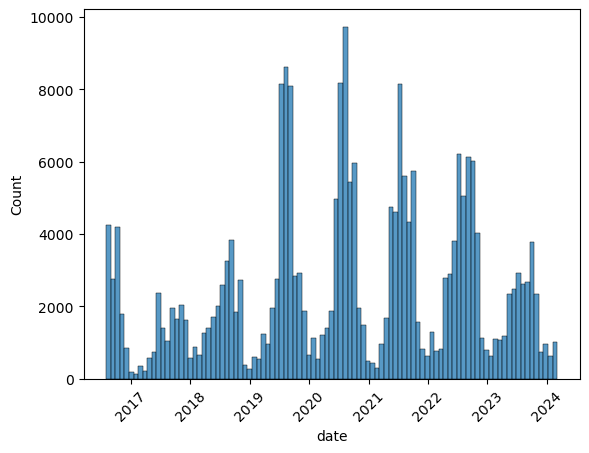

In [76]:
fig, ax = plt.subplots()
sns.histplot(deter, x="date", binwidth=28)
plt.xticks(rotation=45)
plt.show()

In [36]:
# filter dates
deter = deter[
    (deter["date"] >= config.DT_INIT) &
    (deter["date"] <= config.DT_FIM)
]

In [37]:
deter["weekday"] = deter["date"].dt.weekday

In [38]:
deter[deter["weekday"] == 0]["date"].min()

Timestamp('2019-01-21 00:00:00')

In [39]:
deter[deter["weekday"] == 0]["date"].max()

Timestamp('2023-12-25 00:00:00')

In [40]:
# drop days before first monday
deter = deter[
    (deter["date"] >= deter[deter["weekday"] == 0]["date"].min())
]

In [41]:
deter["week_count"] = (deter["date"] - deter["date"].min()).dt.days // 7

In [16]:

# period = "15D"  # 3M | 15D

# if period == "3M":
#     deter["month"] = (deter["date"].dt.quarter - 1) * 3 + 1
#     deter["year"] = deter["date"].dt.year
#     deter["day"] = 1
#     deter["date"] = pd.to_datetime(deter[["year", "month", "day"]])

# elif period == "15D":
#     deter["month"] = deter["date"].dt.month
#     deter["year"] = deter["date"].dt.year
#     deter["day"] = (deter["date"].dt.day // 16).map({0: 1, 1: 16})
#     deter["date"] = pd.to_datetime(deter[["year", "month", "day"]])

In [43]:
periods = range(deter["week_count"].max()+1)
periods

range(0, 258)

# Create full grid

In [44]:
# get rectangle bounds from region
min_x, min_y, max_x, max_y = am_bounds.total_bounds
print(min_x, min_y, max_x, max_y)

-73.9909722199879 -18.04176667000001 -43.95182736291479 5.27222500000003


In [45]:
config.BOX_SIDE

0.01

In [46]:
# generate grid intersection with desired area
nx = int(np.ceil((max_x - min_x) / config.BOX_SIDE))
ny = int(np.ceil((max_y - min_y) / config.BOX_SIDE))
gx, gy = np.linspace(min_x,max_x,nx), np.linspace(min_y,max_y,ny)
grid = []
idx_ = 0
for i in tqdm(list(range(len(gx)-1))):
    for j in range(len(gy)-1):
        poly_ij = Polygon([[gx[i],gy[j]],[gx[i],gy[j+1]],[gx[i+1],gy[j+1]],[gx[i+1],gy[j]]])
        grid.append([idx_,i,j,poly_ij])
        idx_ += 1

100%|██████████████████████████████████████████████████████████████████████████████| 3003/3003 [03:02<00:00, 16.46it/s]


In [47]:
frames = gpd.GeoDataFrame(pd.DataFrame(grid, columns=["frame_id", "x", "y", "geometry"]), crs=am_bounds.crs)
print("Shape:", frames.shape)
frames.head()

Shape: (6999993, 4)


,frame_id,x,y,geometry
0,0,0,0,"POLYGON ((-73.99097 -18.04177, -73.99097 -18.0..."
1,1,0,1,"POLYGON ((-73.99097 -18.03176, -73.99097 -18.0..."
2,2,0,2,"POLYGON ((-73.99097 -18.02176, -73.99097 -18.0..."
3,3,0,3,"POLYGON ((-73.99097 -18.01176, -73.99097 -18.0..."
4,4,0,4,"POLYGON ((-73.99097 -18.00176, -73.99097 -17.9..."


In [48]:
%%time

# assign 'in_borders' column
frames["in_borders"] = frames.intersects(am_bounds.geometry.item())

CPU times: total: 15min 38s
Wall time: 15min 39s


In [49]:
# create a integer column to plot
frames["in_borders_int"] = frames["in_borders"].astype(int)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.39s/it]


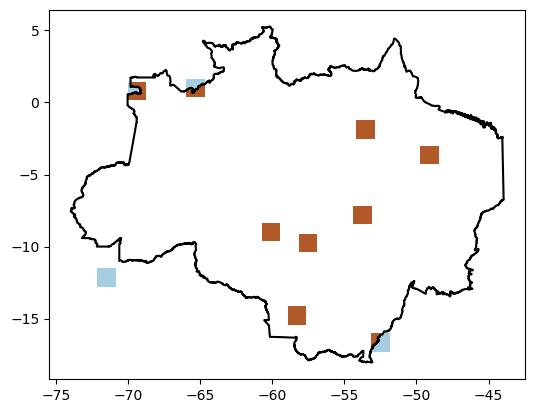

In [50]:
# plot some samples and show borders flag
fig, ax = plt.subplots()
am_bounds.boundary.plot(ax=ax, color="black")
for _ in tqdm(range(10)):
    s = frames.sample()
    x = s["x"].item()
    y = s["y"].item()
    f = frames[
        (frames["x"] > x) &
        (frames["x"] < x+128) &
        (frames["y"] > y) &
        (frames["y"] < y+128)
    ]
    f.plot(column="in_borders_int", cmap="Paired", ax=ax, vmin=0, vmax=1)

plt.show()

In [51]:
# drop the integer column
frames.drop("in_borders_int", axis=1, inplace=True)

# Compute temporal increments by frame

In [52]:
deter.crs == am_bounds.crs

True

In [53]:
frames[frames["in_borders"]].shape

(4123117, 5)

In [54]:
deter.shape

(191275, 17)

In [55]:
%%time

# compute intersection of deforestation areas with grid
increments_by_week = gpd.overlay(
    frames[frames["in_borders"]][["frame_id", "geometry"]], 
    deter[["week_count", "geometry"]].reset_index(),
    how="intersection", 
    keep_geom_type=False
).dissolve(["frame_id", "week_count"]).reset_index()

CPU times: total: 1min 13s
Wall time: 1min 13s


In [56]:
increments_by_week.shape

(397302, 4)

In [57]:
# # get deter warnings from last week
# increments_by_week["last_week_count"] = increments_by_week["week_count"] - 1
# increments_by_week = increments_by_week.merge(
#     increments_by_week[["frame_id", "week_count", "geometry"]].rename(columns={"week_count": "last_week_count"}),
#     on=["frame_id", "last_week_count"],
#     suffixes=("", "_last_week"),
#     how="left",
#     validate="1:1"
# )

In [58]:
# # get deter warnings from next week
# increments_by_week["next_week_count"] = increments_by_week["week_count"] + 1
# increments_by_week = increments_by_week.merge(
#     increments_by_week[["frame_id", "week_count", "geometry"]].rename(columns={"week_count": "next_week_count"}),
#     on=["frame_id", "next_week_count"],
#     suffixes=("", "_next_week"),
#     how="left",
#     validate="1:1"
# )

In [59]:
# # sum this week geometry with next week geometry
# increments_by_week["geometry_sum"] = increments_by_week["geometry"].union(increments_by_week["geometry_next_week"])
# increments_by_week.loc[
#     increments_by_week["geometry_sum"].isna(),
#     "geometry_sum"
# ] = increments_by_week["geometry"]

In [60]:
# # complete dataset with "last weeks" with no warning
# not_increment_last_week = increments_by_week[
#     increments_by_week["geometry_last_week"].isna()
# ]
# not_increment_last_week = not_increment_last_week[["frame_id", "geometry", "last_week_count"]].rename(
#     columns={
#         "geometry": "geometry_sum",
#         "last_week_count": "week_count"
#     }
# )

# increments_by_week = pd.concat([increments_by_week, not_increment_last_week], axis=0)

In [61]:
# increments_by_week = increments_by_week[increments_by_week["week_count"] >= 0]

In [62]:
increments_by_week.shape

(397302, 4)

In [63]:
increments_by_week.isna().mean()

frame_id      0.0
week_count    0.0
geometry      0.0
index         0.0
dtype: float64

<Axes: ylabel='Count'>

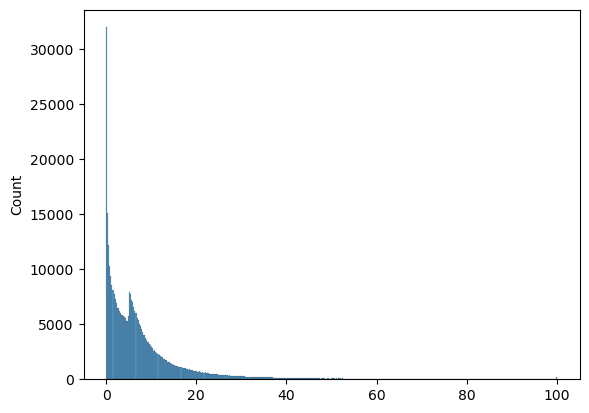

In [64]:
sns.histplot(increments_by_week.geometry.area / 1e-6)

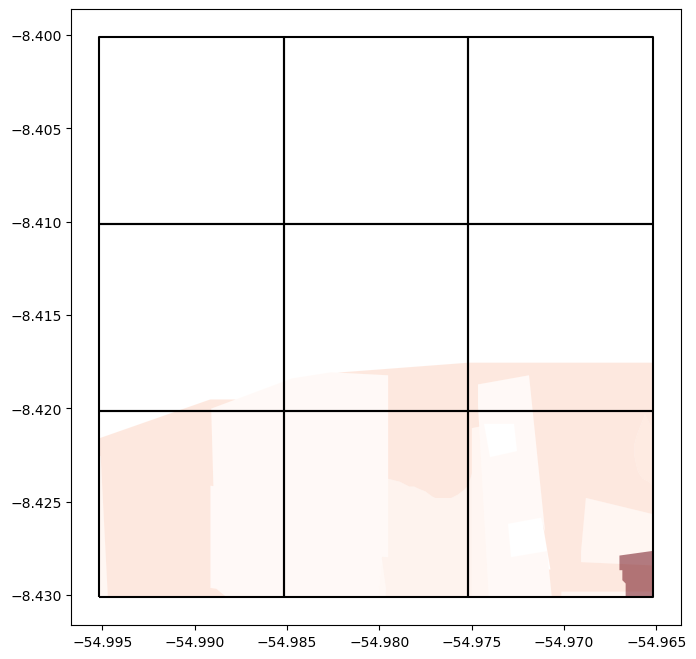

In [65]:
# plot sample area
frame_id_ = increments_by_week.sample()["frame_id"].item()
k = increments_by_week[
    ((increments_by_week["frame_id"] - frame_id_).abs() < 2) |
    ((increments_by_week["frame_id"] + ny - 1 - frame_id_).abs() < 2) |
    ((increments_by_week["frame_id"] - ny + 1 - frame_id_).abs() < 2)
].copy()
fig, ax = plt.subplots(figsize=(8, 8))
frames[
    ((frames["frame_id"] - frame_id_).abs() < 2) |
    ((frames["frame_id"] + ny - 1 - frame_id_).abs() < 2) |
    ((frames["frame_id"] - ny + 1 - frame_id_).abs() < 2)
].boundary.plot(ax=ax, color="black")
k.plot(column="week_count", ax=ax, cmap="Reds", alpha=.5)
plt.show()

# Compute area by frame

In [66]:
unit_frame_area = config.BOX_SIDE**2
increments_by_week["area"] = increments_by_week["geometry"].area / unit_frame_area

In [67]:
increments_by_week.shape

(397302, 5)

In [68]:
increments_by_week.shape[0] / (frames["in_borders"].sum() * (increments_by_week["week_count"].max()+1))

0.00037348691113013273

In [69]:
# add date
increments_by_week["date"] = increments_by_week["week_count"].map(deter.groupby("week_count")["date"].min())

# Save files

In [71]:
# save all frames geo-coordinates
frames.to_file(config.TR_FRAMES)

# save frames idx documentation
frames[["frame_id", "x", "y", "in_borders"]].to_csv(config.TR_FRAMES_IDX)

# save increments history
increments_by_week[["frame_id", "date", "week_count", "area"]].to_csv(config.TR_DEFORESTATION)

## Save as raster

In [ ]:
from geocube.api.core import make_geocube

# create pivoted table
increments_by_week["date"] = increments_by_week["date"].dt.strftime("%Y-%m-%d")
increments_raster = gpd.GeoDataFrame(
    increments_by_week.pivot_table(values="area", index="frame_id", columns="date")\
    .fillna(0)\
    .reset_index()
)
date_cols = increments_raster.columns[1:]

In [ ]:
# add geometry (to raster correctly)
increments_raster = increments_raster.merge(
    frames[["frame_id", "geometry"]], 
    on="frame_id", 
    how="left",
    validate="1:1"
)

In [ ]:
# raster data with bands by date
out_grid = make_geocube(
    vector_data=increments_raster,
    resolution=(0.01, 0.01),
    measurements=list(date_cols),
    geom=am_bounds.geometry.item(),
    fill=0.0
)

In [ ]:
# save
out_grid.rio.to_raster("deter_increments_1km_1week.tif")